## Import modules

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
import warnings
from textblob import TextBlob
from wordcloud import WordCloud
from nltk.corpus import stopwords

# Set up plotting
%matplotlib inline

# Download NLTK stopwords
nltk.download('stopwords')

# Suppress warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Loading the dataset

In [2]:
# Read the CSV file into a Pandas DataFrame
df = pd.read_csv('tweets_v8.csv')
df.head()

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,source,is_retweet
0,the _ûndër-ratèd niggáh👊🏾,NaN,@ManUtd die hard❤️❤️💪🏿💪🏿\n\n\nYOLO\n\n\nJ'ai b...,2019-09-06 19:24:57+00:00,581,1035,8922,False,2021-10-06 12:05:38+00:00,When life hits and the same time poverty strik...,Twitter for Android,False
1,Best uncle on planet earth,NaN,NaN,2013-05-08 19:35:26+00:00,741,730,8432,False,2021-10-06 12:05:22+00:00,That marble episode of #SquidGame ruined me. 😭😭😭,Twitter for Android,False
2,marcie,NaN,animal crossing. chicken nuggets. baby yoda. s...,2009-02-21 10:31:30+00:00,562,1197,62732,False,2021-10-06 12:05:22+00:00,#Squidgame time,Twitter Web App,False
3,YoMo.Mdp,Any pronouns,Where the heck is the karma\nI'm going on my s...,2021-02-14 13:21:22+00:00,3,277,1341,False,2021-10-06 12:05:04+00:00,//Blood on 1st slide\nI'm joining the squidgam...,Twitter Web App,False
4,Laura Reactions,France,I talk and I make reactions videos about shows...,2018-12-19 20:38:28+00:00,330,152,2278,False,2021-10-06 12:05:00+00:00,"The two first games, players were killed by th...",Twitter Web App,False


In [3]:
# Display information about the DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80019 entries, 0 to 80018
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   user_name         80015 non-null  object
 1   user_location     56149 non-null  object
 2   user_description  74808 non-null  object
 3   user_created      80019 non-null  object
 4   user_followers    80019 non-null  int64 
 5   user_friends      80019 non-null  int64 
 6   user_favourites   80019 non-null  int64 
 7   user_verified     80019 non-null  bool  
 8   date              80019 non-null  object
 9   text              80019 non-null  object
 10  source            80019 non-null  object
 11  is_retweet        80019 non-null  bool  
dtypes: bool(2), int64(3), object(7)
memory usage: 6.3+ MB


In [4]:
# List of columns to drop from the DataFrame
columns_to_drop = ['user_name', 'user_location', 'user_description', 'user_created', 'user_followers', 'user_friends', 'user_favourites', 'user_verified', 'date', 'source', 'is_retweet']

# Drop specified columns from the DataFrame
df = df.drop(columns=columns_to_drop)

## Preprocessing the dataset

In [5]:
# Define a function to remove a specific pattern from text
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for word in r:
        input_txt = re.sub(word, "", input_txt)
    return input_txt

In [7]:
# Apply the remove_pattern function to remove Twitter handles from the 'text' column
df['clean_tweet'] = np.vectorize(remove_pattern)(df['text'], "@[\w]*")
df.head()

In [9]:
# Remove special characters, numbers, and punctuations from the 'clean_tweet' column
df['clean_tweet'] = df['clean_tweet'].str.replace("[^a-zA-Z#]", " ")
df.head()

,text,clean_tweet
0,When life hits and the same time poverty strik...,When life hits and the same time poverty strik...
1,That marble episode of #SquidGame ruined me. 😭😭😭,That marble episode of #SquidGame ruined me
2,#Squidgame time,#Squidgame time
3,//Blood on 1st slide\nI'm joining the squidgam...,Blood on st slide I m joining the squidgame...
4,"The two first games, players were killed by th...",The two first games players were killed by th...


In [10]:
# Remove short words (length less than 3) from the 'clean_tweet' column
df['clean_tweet'] = df['clean_tweet'].apply(lambda x: " ".join([w for w in x.split() if len(w) > 3]))
df.head()

,text,clean_tweet
0,When life hits and the same time poverty strik...,When life hits same time poverty strikes Gong ...
1,That marble episode of #SquidGame ruined me. 😭😭😭,That marble episode #SquidGame ruined
2,#Squidgame time,#Squidgame time
3,//Blood on 1st slide\nI'm joining the squidgam...,Blood slide joining squidgame thing already de...
4,"The two first games, players were killed by th...",first games players were killed mask guys bloo...


In [11]:
# Tokenize the 'clean_tweet' column into individual words
tokenized_tweet = df['clean_tweet'].apply(lambda x: x.split())
tokenized_tweet.head()

0    [When, life, hits, same, time, poverty, strike...
1          [That, marble, episode, #SquidGame, ruined]
2                                   [#Squidgame, time]
3    [Blood, slide, joining, squidgame, thing, alre...
4    [first, games, players, were, killed, mask, gu...
Name: clean_tweet, dtype: object

In [12]:
# Stem the words using Porter Stemmer
from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()
tokenized_tweet = tokenized_tweet.apply(lambda sentence: [stemmer.stem(word) for word in sentence])
tokenized_tweet.head()

0    [when, life, hit, same, time, poverti, strike,...
1               [that, marbl, episod, #squidgam, ruin]
2                                    [#squidgam, time]
3    [blood, slide, join, squidgam, thing, alreadi,...
4    [first, game, player, were, kill, mask, guy, b...
Name: clean_tweet, dtype: object

In [13]:
# Combine the stemmed words into a single sentence
for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = " ".join(tokenized_tweet[i])

# Update the 'clean_tweet' column with the tokenized and stemmed text
df['clean_tweet'] = tokenized_tweet
df.head()

,text,clean_tweet
0,When life hits and the same time poverty strik...,when life hit same time poverti strike gong le...
1,That marble episode of #SquidGame ruined me. 😭😭😭,that marbl episod #squidgam ruin
2,#Squidgame time,#squidgam time
3,//Blood on 1st slide\nI'm joining the squidgam...,blood slide join squidgam thing alreadi dead s...
4,"The two first games, players were killed by th...",first game player were kill mask guy bloodi ni...


## Exploratory Data Analysis

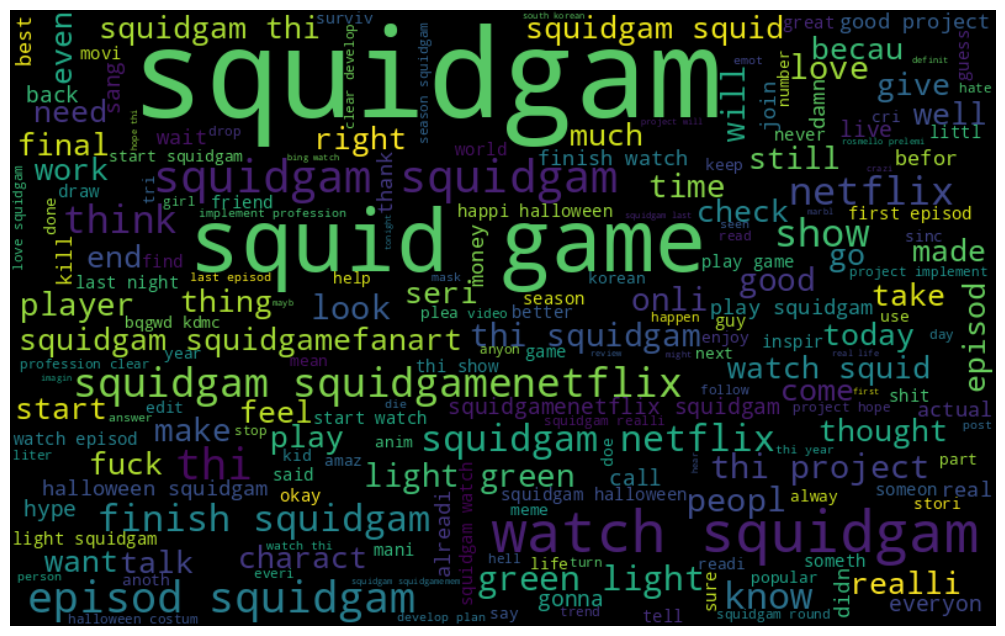

In [14]:
# Visualize the frequent words using WordCloud
all_words = " ".join([sentence for sentence in df['clean_tweet']])
wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(all_words)

# Plot the WordCloud
plt.figure(figsize=(15, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

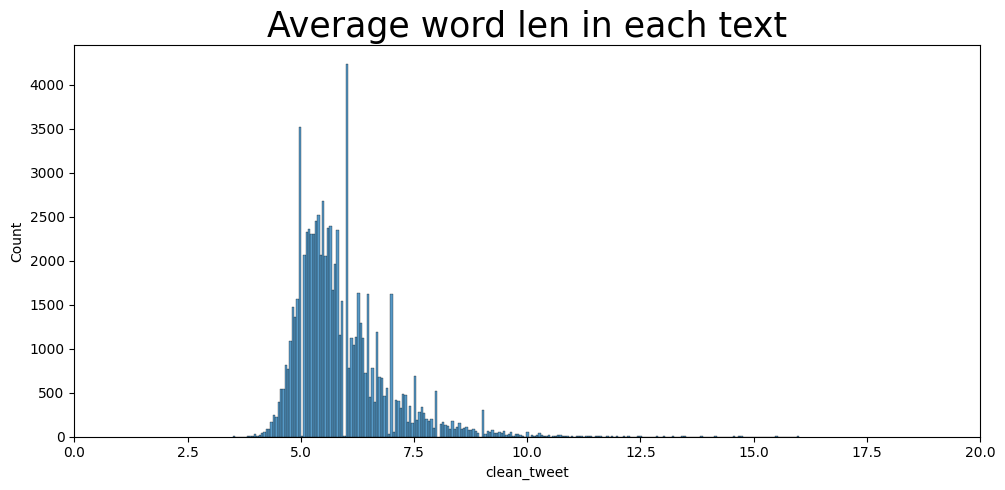

In [15]:
# Visualize the distribution of average word lengths in each text
fig = plt.figure(figsize=(10, 5))
word = df.clean_tweet.str.split().apply(lambda x: [len(i) for i in x])
sns.histplot(word.apply(lambda x: np.mean(x)))
plt.title('Average word len in each text', fontsize=25)
plt.tight_layout()
plt.xlim([0, 20])
plt.show()

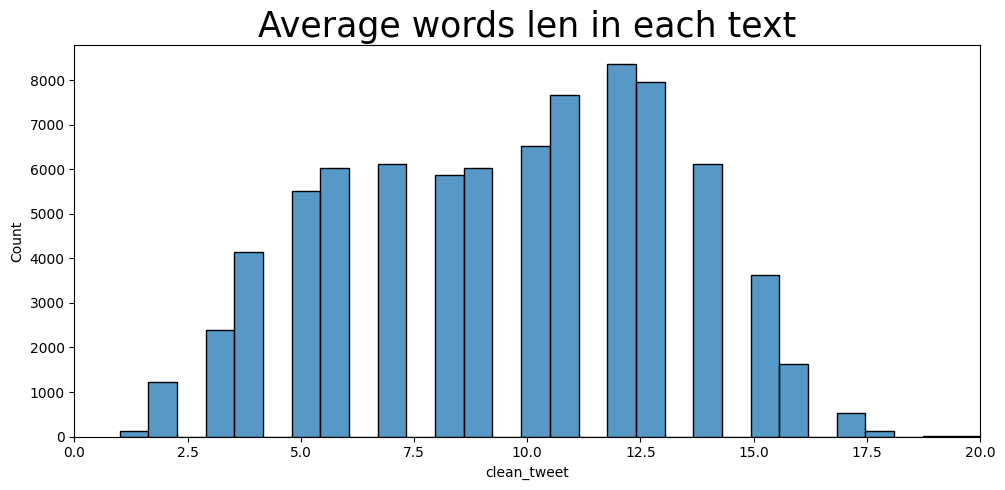

In [16]:
# Visualize the distribution of average words length in each text
fig = plt.figure(figsize=(10, 5))
word = df.clean_tweet.str.split().apply(lambda x: len(x))
sns.histplot(word.apply(lambda x: np.mean(x)), bins=30)
plt.title('Average words len in each text', fontsize=25)
plt.tight_layout()
plt.xlim([0, 20])
plt.show()

Sentiment Analysis

In [17]:
# Define functions to calculate polarity, subjectivity, and sentiment
def polarity(text):
    testimonial = TextBlob(text)
    polarity = testimonial.sentiment.polarity
    return polarity

def subjectivity(text):
    testimonial = TextBlob(text)
    subjectivity = testimonial.subjectivity
    return subjectivity

def senti(text, polarity_threshold=0.0):
    testimonial = TextBlob(text)
    senti = testimonial.sentiment.polarity

    if senti > polarity_threshold:
        return 'Positive'
    elif np.abs(senti) == polarity_threshold:
        return 'Neutral'
    else:
        return 'Negative'

# Apply sentiment analysis functions to create new columns in the DataFrame
df['polarity'] = df.clean_tweet.apply(lambda x: polarity(x))
df['subjectivity'] = df.clean_tweet.apply(lambda x: subjectivity(x))
df['sentiment'] = df.clean_tweet.apply(lambda x: senti(x))
df.head()

,text,clean_tweet,polarity,subjectivity,sentiment
0,When life hits and the same time poverty strik...,when life hit same time poverti strike gong le...,-0.2000,0.262500,Negative
1,That marble episode of #SquidGame ruined me. 😭😭😭,that marbl episod #squidgam ruin,0.0000,0.000000,Neutral
2,#Squidgame time,#squidgam time,0.0000,0.000000,Neutral
3,//Blood on 1st slide\nI'm joining the squidgam...,blood slide join squidgam thing alreadi dead s...,-0.2000,0.400000,Negative
4,"The two first games, players were killed by th...",first game player were kill mask guy bloodi ni...,-0.1375,0.283333,Negative


<Axes: xlabel='sentiment', ylabel='count'>

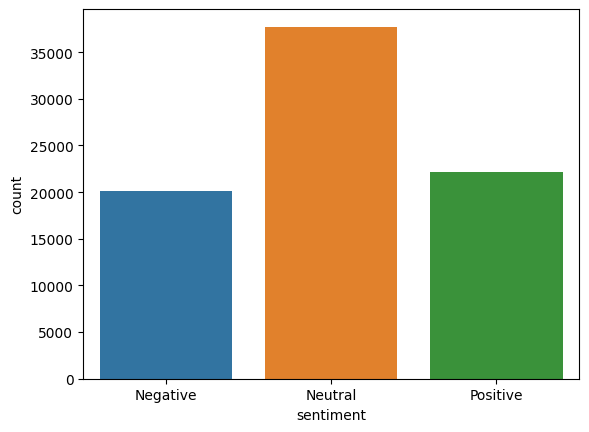

In [18]:
# Visualize the distribution of sentiments
sns.countplot(x='sentiment', data=df)

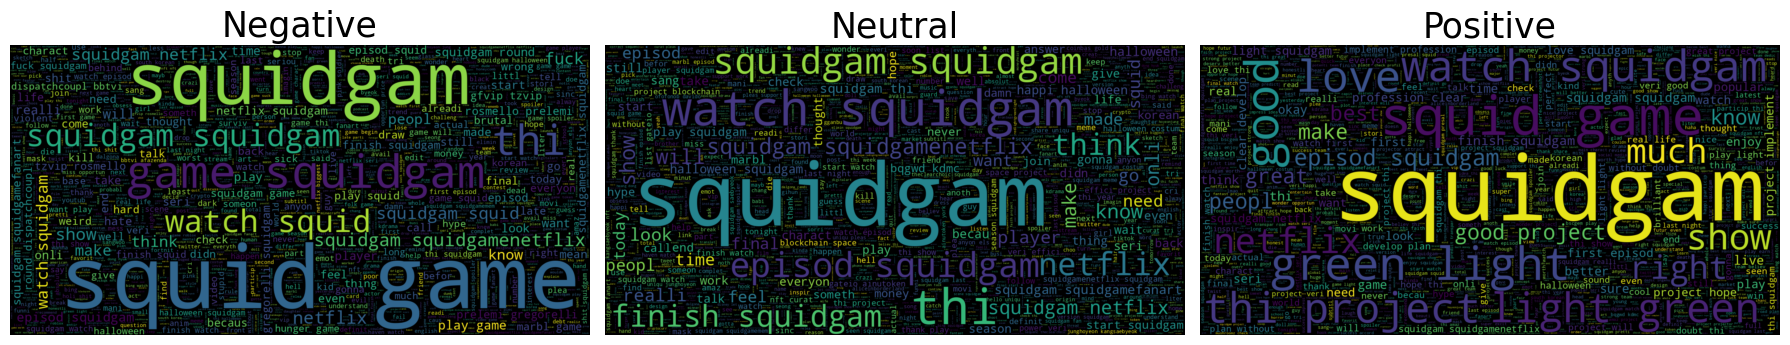

In [19]:
# Visualize WordClouds for each sentiment
fig, ax = plt.subplots(1, 3, figsize=(18, 8))
sentiments = df['sentiment'].unique()
for i, senti in enumerate(sentiments):
    senti_df = df.query('sentiment==@senti')
    cloud = ' '.join([tweet for tweet in senti_df['clean_tweet']])
    wc = WordCloud(max_words=2000, width=1600, height=800).generate(cloud)

    ax[i].set_title(senti, fontsize=25)
    ax[i].axis('off')
    ax[i].imshow(wc, interpolation='bilinear')

plt.tight_layout()
plt.show()